In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
np.random.seed(42)

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
################# cGAN Model  #################
################# cGAN Model #################
def build_discriminator(no_of_classes):
    input_image = layers.Input(shape=(28,28,1))
    input_label = layers.Input(shape=(no_of_classes,))
    
    l = layers.Dense(32, activation='relu')(input_label) 
    l = layers.Dense(28*28*1, activation='relu')(l) 
    l = layers.Reshape((28,28,1))(l) 
    d = layers.Concatenate()([input_image, l])
    
    d = layers.Conv2D(32, 4, strides=2, padding='same', activation = 'relu')(d)	
    d = layers.Conv2D(64, 4, strides=2, padding='same', activation = 'relu')(d)
    d = layers.Conv2D(128,4, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Conv2D(256,4, strides=2, padding='same', activation = 'relu')(d)
    d = layers.Conv2D(512,4, strides=2, padding='same', activation = 'relu')(d)  
    d = layers.Flatten()(d)
    d = layers.Dense(128, activation='relu')(d)  
    d = layers.Dropout(0.3)(d)
    d = layers.Dense(128, activation='relu')(d)  
    output = layers.Dense(1, activation='sigmoid')(d)
    model = models.Model([input_image,input_label], output)
    model.summary()
    return model

def build_generator(latent_dim,no_of_classes):
    input_layer = layers.Input(shape=(latent_dim,))   
    input_label = layers.Input(shape=(no_of_classes,))
    
    d = layers.Concatenate()([input_layer, input_label])
    d = layers.Dense(64, activation='relu', )(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(128, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(256, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(512, activation='relu')(d)
    d = layers.BatchNormalization(momentum = 0.8)(d)
    d = layers.Dense(7*7*64, activation='relu')(d)
    d = layers.Reshape((7, 7, 64))(d)    

    # Decoder (Upsampling)   
    d = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(d) 
    d = layers.BatchNormalization(momentum = 0.8)(d)
    output_layer = layers.Conv2DTranspose(1, 3, activation='tanh', strides=2, padding='same')(d)  
    
    # Output layer
    model = models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    model.summary()        
    return model

def build_gan(generator, discriminator, latent_dim, no_of_classes):
    latent_vector = layers.Input(shape = (latent_dim,)) 
    input_label = layers.Input(shape = (10,)) 
    
    fake_img = generator([latent_vector,input_label]) 
    
    discriminator.trainable = False
    gan_output = discriminator([fake_img,input_label])
    
    gan = models.Model(inputs = [latent_vector,input_label], outputs = gan_output)
    gan.summary()
    return gan

In [3]:
def create_fake_labels(batch_size,no_of_classes):
    random_columns = np.random.choice(no_of_classes, size=batch_size)
    rows = np.arange(batch_size)            
    fake_labels = np.zeros((batch_size, no_of_classes))
    fake_labels[rows,random_columns] = 1
    return fake_labels

from tqdm import tqdm
def train(discriminator, generator, latent_dimension, gan, x_train, y_train, n_epochs, batch_size):
    d_loss = []
    g_loss = []
    for i in range(n_epochs):
        no_of_iterations = x_train.shape[0]//batch_size	               
        for j in tqdm(range(no_of_iterations)):
            idx = np.random.choice(np.arange(x_train.shape[0]),batch_size)
            real_images = x_train[idx]
            real_lables = y_train[idx]
            
            latent_vector = np.random.normal(0, 1, (batch_size, latent_dimension))  
            fake_labels = create_fake_labels(batch_size,no_of_classes)  
            fake_images = generator.predict_on_batch([latent_vector,fake_labels])

            discriminator.trainable = True
            ######### Introducing noisy labels during discriminator training to prevent mode collapse:
            if np.random.rand()>0.2:
                d_loss1 = discriminator.train_on_batch([fake_images, fake_labels],np.zeros((batch_size,)))	
                d_loss2 = discriminator.train_on_batch([real_images, real_lables],np.ones((batch_size,)))   
            else:
                d_loss1 = discriminator.train_on_batch([fake_images, fake_labels],np.ones((batch_size,))) #noisy labels	
                d_loss2 = discriminator.train_on_batch([real_images, real_lables],np.zeros((batch_size,))) #noisy labels	
            d_loss.append(0.5*np.add(d_loss1,d_loss2))			
            
            discriminator.trainable = False
            latent_vector = np.random.normal(0, 1, (batch_size, latent_dimension)) 
            fake_labels = create_fake_labels(batch_size,no_of_classes)            
            g_loss.append(gan.train_on_batch([latent_vector , fake_labels],np.ones((batch_size,))))             
        
        # Generate Random Fake Images at the end of each Epoch
        latent_vector = np.random.normal(0, 1, (5, latent_dimension)) 
        fake_labels = create_fake_labels(5,no_of_classes)    
        fake_images = generator.predict_on_batch([latent_vector,fake_labels])
        for k in range(5):
            plt.subplot(1,5,k+1)
            plt.imshow(fake_images[k])
            plt.axis('off')
        plt.draw()
        plt.pause(0.0001)
        
        print('Epoch = '+str(i+1)+', G Loss = '+str(g_loss[-1])+', D Loss = '+str(d_loss[-1]))    
    return d_loss, g_loss


In [5]:
latent_dimension = 100
no_of_classes = 10

discriminator = build_discriminator(no_of_classes)
discriminator.compile(optimizer = tf.keras.optimizers.Adam(0.0001, 0.5), loss='binary_crossentropy')

generator = build_generator(latent_dimension, no_of_classes)

gan = build_gan(generator, discriminator, latent_dimension, no_of_classes)
gan.compile(optimizer =  tf.keras.optimizers.Adam(0.0001, 0.5), loss='binary_crossentropy')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           352         input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          25872       dense[0][0]                      
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:27<00:00, 16.83it/s]


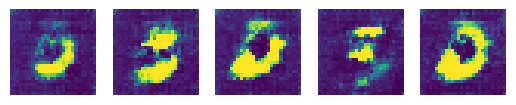

Epoch = 1, G Loss = 0.6259807348251343, D Loss = 0.7533950507640839


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.41it/s]


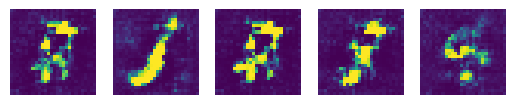

Epoch = 2, G Loss = 0.6930528879165649, D Loss = 0.7489868402481079


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 21.22it/s]


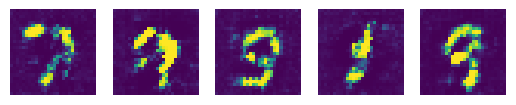

Epoch = 3, G Loss = 0.7639521360397339, D Loss = 0.6750881671905518


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.71it/s]


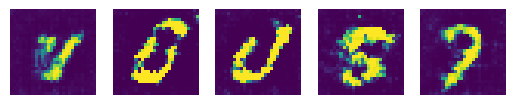

Epoch = 4, G Loss = 0.7527428865432739, D Loss = 0.6770859956741333


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.58it/s]


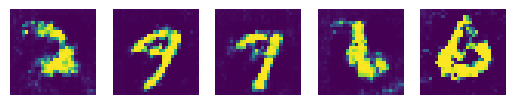

Epoch = 5, G Loss = 0.7382989525794983, D Loss = 0.6787903904914856


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.67it/s]


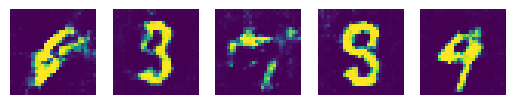

Epoch = 6, G Loss = 0.7988684773445129, D Loss = 0.6531561017036438


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.81it/s]


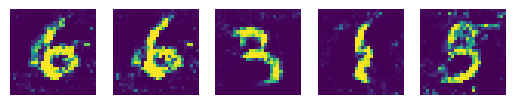

Epoch = 7, G Loss = 1.1608612537384033, D Loss = 0.5213258117437363


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.65it/s]


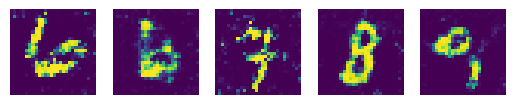

Epoch = 8, G Loss = 1.232488751411438, D Loss = 1.3410485982894897


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.84it/s]


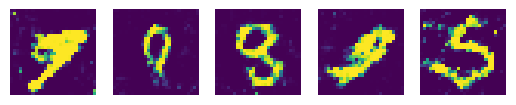

Epoch = 9, G Loss = 1.4010756015777588, D Loss = 0.3873864412307739


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.74it/s]


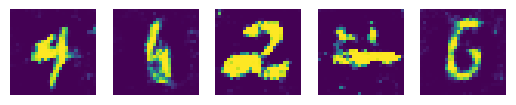

Epoch = 10, G Loss = 0.9168001413345337, D Loss = 1.058319628238678


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.37it/s]


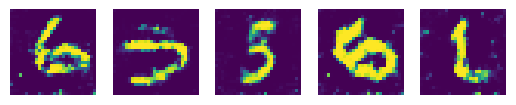

Epoch = 11, G Loss = 1.1194779872894287, D Loss = 0.48480959236621857


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.28it/s]


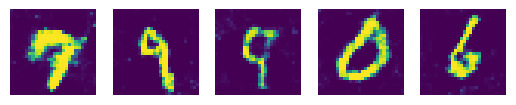

Epoch = 12, G Loss = 1.0653724670410156, D Loss = 1.1236412525177002


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00, 20.29it/s]


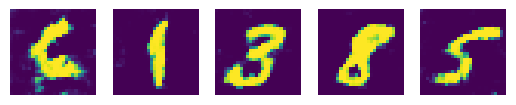

Epoch = 13, G Loss = 1.09063720703125, D Loss = 0.5815789103507996


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 21.22it/s]


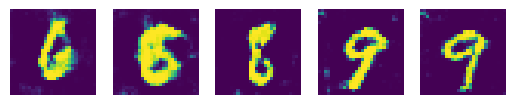

Epoch = 14, G Loss = 0.8923989534378052, D Loss = 0.6154805421829224


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.50it/s]


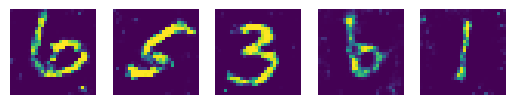

Epoch = 15, G Loss = 0.7969653606414795, D Loss = 0.6336503326892853


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.45it/s]


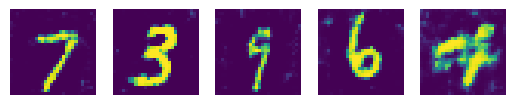

Epoch = 16, G Loss = 0.7023862600326538, D Loss = 0.7287643253803253


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.57it/s]


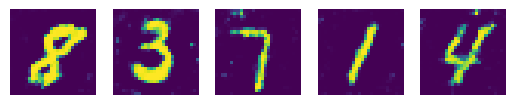

Epoch = 17, G Loss = 0.7077418565750122, D Loss = 0.8111611008644104


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.64it/s]


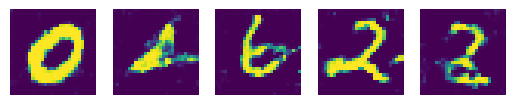

Epoch = 18, G Loss = 0.8669853210449219, D Loss = 0.6115719079971313


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.54it/s]


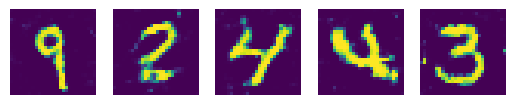

Epoch = 19, G Loss = 0.8073225021362305, D Loss = 0.6425646543502808


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.62it/s]


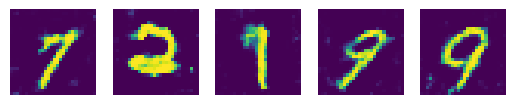

Epoch = 20, G Loss = 0.7705487012863159, D Loss = 0.6507782340049744


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.44it/s]


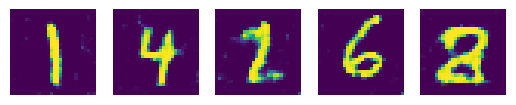

Epoch = 21, G Loss = 0.7970739603042603, D Loss = 0.6528421342372894


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.56it/s]


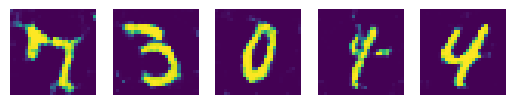

Epoch = 22, G Loss = 0.8343764543533325, D Loss = 0.6410002112388611


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.61it/s]


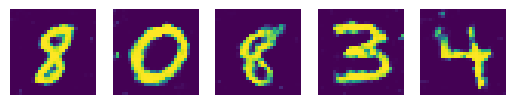

Epoch = 23, G Loss = 0.8045399188995361, D Loss = 0.6318307518959045


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 20.97it/s]


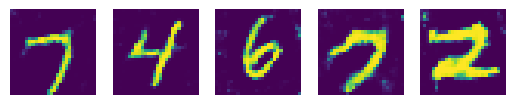

Epoch = 24, G Loss = 0.7586137652397156, D Loss = 0.6719389259815216


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.49it/s]


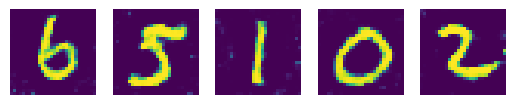

Epoch = 25, G Loss = 0.7741489410400391, D Loss = 0.6484725773334503


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.58it/s]


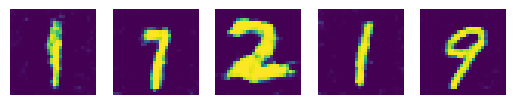

Epoch = 26, G Loss = 0.7224007844924927, D Loss = 0.6792348623275757


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.42it/s]


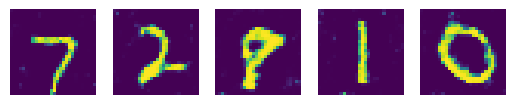

Epoch = 27, G Loss = 0.6753405332565308, D Loss = 0.7315784096717834


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.66it/s]


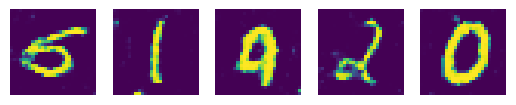

Epoch = 28, G Loss = 0.7426819205284119, D Loss = 0.6518069505691528


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.68it/s]


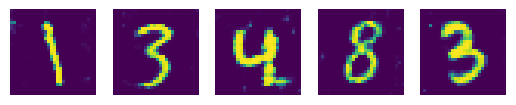

Epoch = 29, G Loss = 0.8473420739173889, D Loss = 0.6575077474117279


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.40it/s]


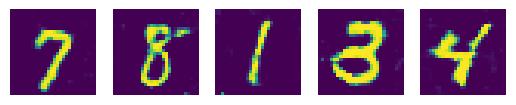

Epoch = 30, G Loss = 0.7862189412117004, D Loss = 0.632514238357544


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.68it/s]


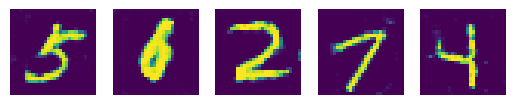

Epoch = 31, G Loss = 0.7431749701499939, D Loss = 0.7474223971366882


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.58it/s]


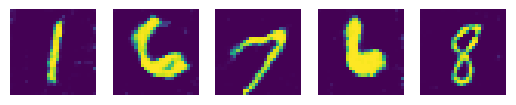

Epoch = 32, G Loss = 0.7643246650695801, D Loss = 0.656880110502243


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.44it/s]


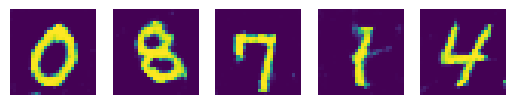

Epoch = 33, G Loss = 0.8564386963844299, D Loss = 0.6095046103000641


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.64it/s]


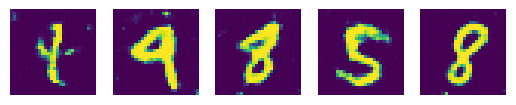

Epoch = 34, G Loss = 0.7515540719032288, D Loss = 0.658086359500885


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.60it/s]


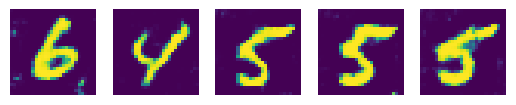

Epoch = 35, G Loss = 0.7251483201980591, D Loss = 0.6627465188503265


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.44it/s]


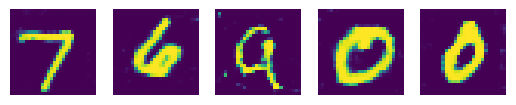

Epoch = 36, G Loss = 0.751315712928772, D Loss = 0.651813268661499


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.64it/s]


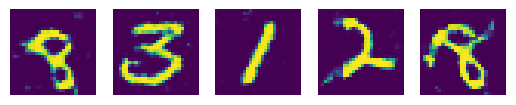

Epoch = 37, G Loss = 0.7540912628173828, D Loss = 0.6561358869075775


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.54it/s]


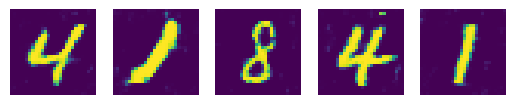

Epoch = 38, G Loss = 0.8525019884109497, D Loss = 0.6470312476158142


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.59it/s]


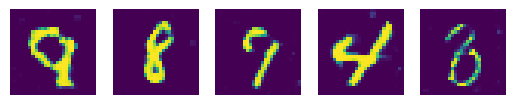

Epoch = 39, G Loss = 0.7813025712966919, D Loss = 0.6342535316944122


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.71it/s]


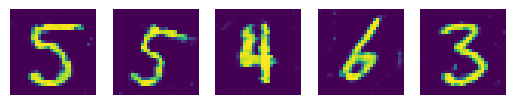

Epoch = 40, G Loss = 0.7709992527961731, D Loss = 0.6658873558044434


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.58it/s]


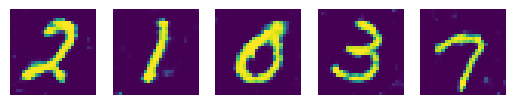

Epoch = 41, G Loss = 0.917466402053833, D Loss = 0.6024872064590454


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.55it/s]


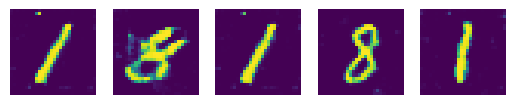

Epoch = 42, G Loss = 0.7945846319198608, D Loss = 0.6348750293254852


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.48it/s]


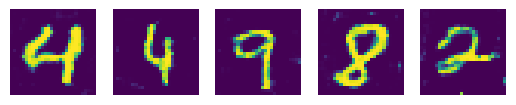

Epoch = 43, G Loss = 0.8460025787353516, D Loss = 0.652321994304657


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.49it/s]


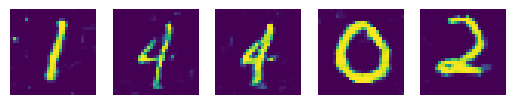

Epoch = 44, G Loss = 0.8774457573890686, D Loss = 0.62447389960289


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.58it/s]


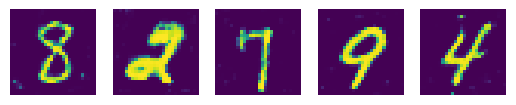

Epoch = 45, G Loss = 0.8096268773078918, D Loss = 0.6443568468093872


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.44it/s]


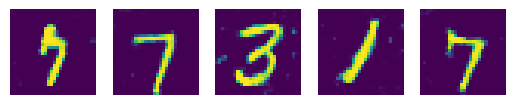

Epoch = 46, G Loss = 0.8310871124267578, D Loss = 0.6261851787567139


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.42it/s]


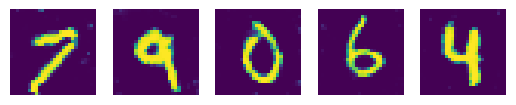

Epoch = 47, G Loss = 0.8387888073921204, D Loss = 0.6120959520339966


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.59it/s]


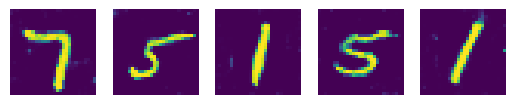

Epoch = 48, G Loss = 0.7768902778625488, D Loss = 0.6478650569915771


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.45it/s]


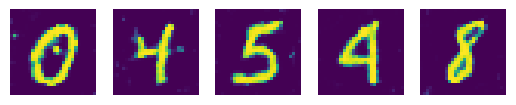

Epoch = 49, G Loss = 0.8541578054428101, D Loss = 0.6243906021118164


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 21.57it/s]


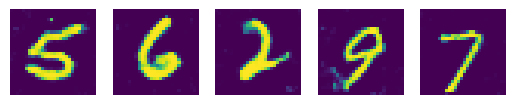

Epoch = 50, G Loss = 0.7744112014770508, D Loss = 0.6456222534179688


In [6]:
d_loss, g_loss = train(discriminator, generator, latent_dimension, gan, x_train, y_train, n_epochs = 50, batch_size = 128)

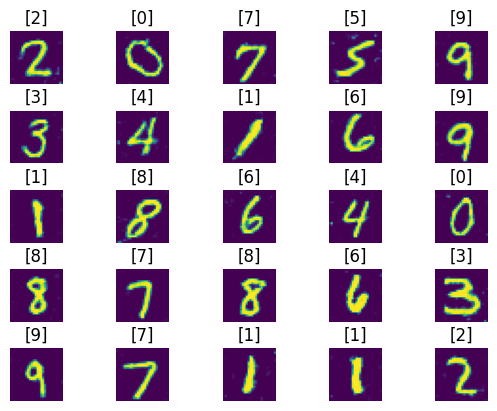

In [12]:
latent_vector = np.random.normal(0, 1, (25, latent_dimension))   
fake_labels = create_fake_labels(25,no_of_classes)  
fake_images = generator.predict_on_batch([latent_vector,fake_labels])
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(fake_images[k])
    plt.axis('off')
    plt.title(np.argwhere(fake_labels[k,:]==1)[0])
plt.subplots_adjust(wspace=0.5, hspace=0.5) 